In [2]:
import matplotlib.pyplot as plt


In [3]:
import librosa
import librosa.feature
import librosa.display
# import librosa.display
import soundfile
import numpy as np 
import scipy
import torchaudio
import torch

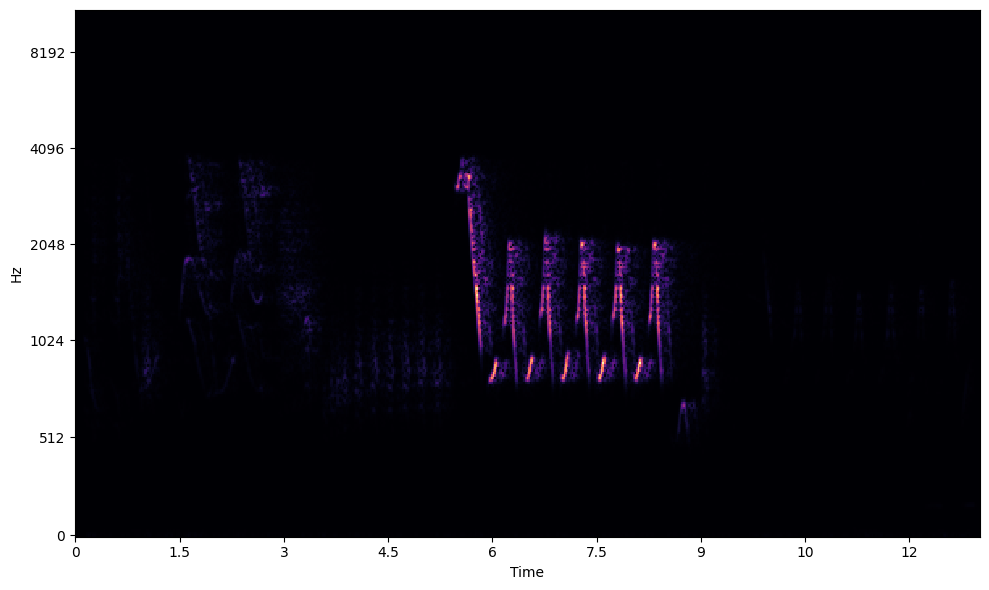

In [4]:


bird_sing, sr = librosa.load("audio_16k/bird-sing.wav")

stft = librosa.stft(bird_sing, n_fft=512)

# plot
plt.figure(figsize=(10, 6))
librosa.display.specshow(np.abs(stft), sr=sr, n_fft=512, x_axis='time', y_axis='mel')
plt.tight_layout()
plt.show()


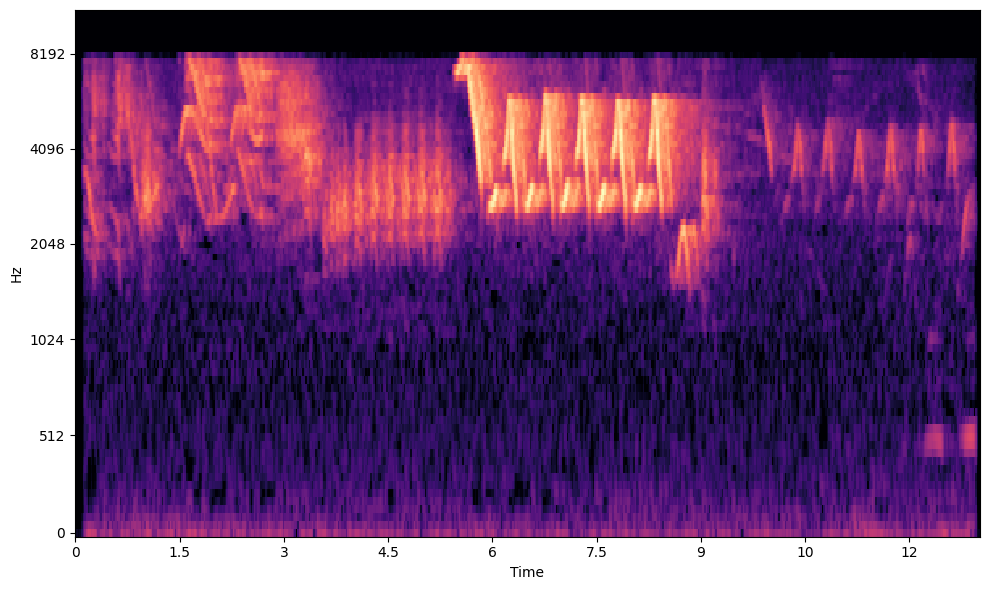

In [5]:
mel_spec = librosa.feature.melspectrogram(y=bird_sing, sr=sr, n_fft=512, hop_length=128, n_mels=80)
toDb = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(toDb, x_axis='time',
                         y_axis='mel', sr=sr)
plt.tight_layout()
plt.show()


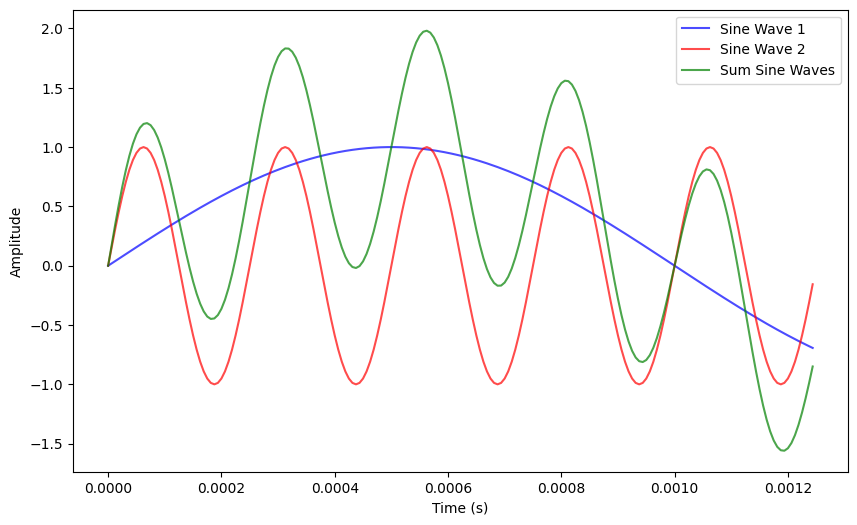

In [6]:
sr = 160000
duration = 3
feq_A = 500
feq_B = 4000
time_span = np.linspace(0, duration, sr*duration)

# to simualte y(t)=Asin(2pi * f * t) -> omega = 2pi*f
wave_A = np.sin(2 * np.pi * feq_A * time_span) 
wave_B = np.sin(2 * np.pi * feq_B * time_span)
wave_sum = wave_A + wave_B

waves = [wave_A, wave_B, wave_sum]

plt.figure(figsize=(10,6))
plt.plot(time_span[:200], wave_A[:200], color='blue', alpha=0.7, label='Sine Wave 1')
plt.plot(time_span[:200], wave_B[:200], color='red', alpha=0.7, label='Sine Wave 2')
plt.plot(time_span[:200], wave_sum[:200], color='green', alpha=0.7, label='Sum Sine Waves')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


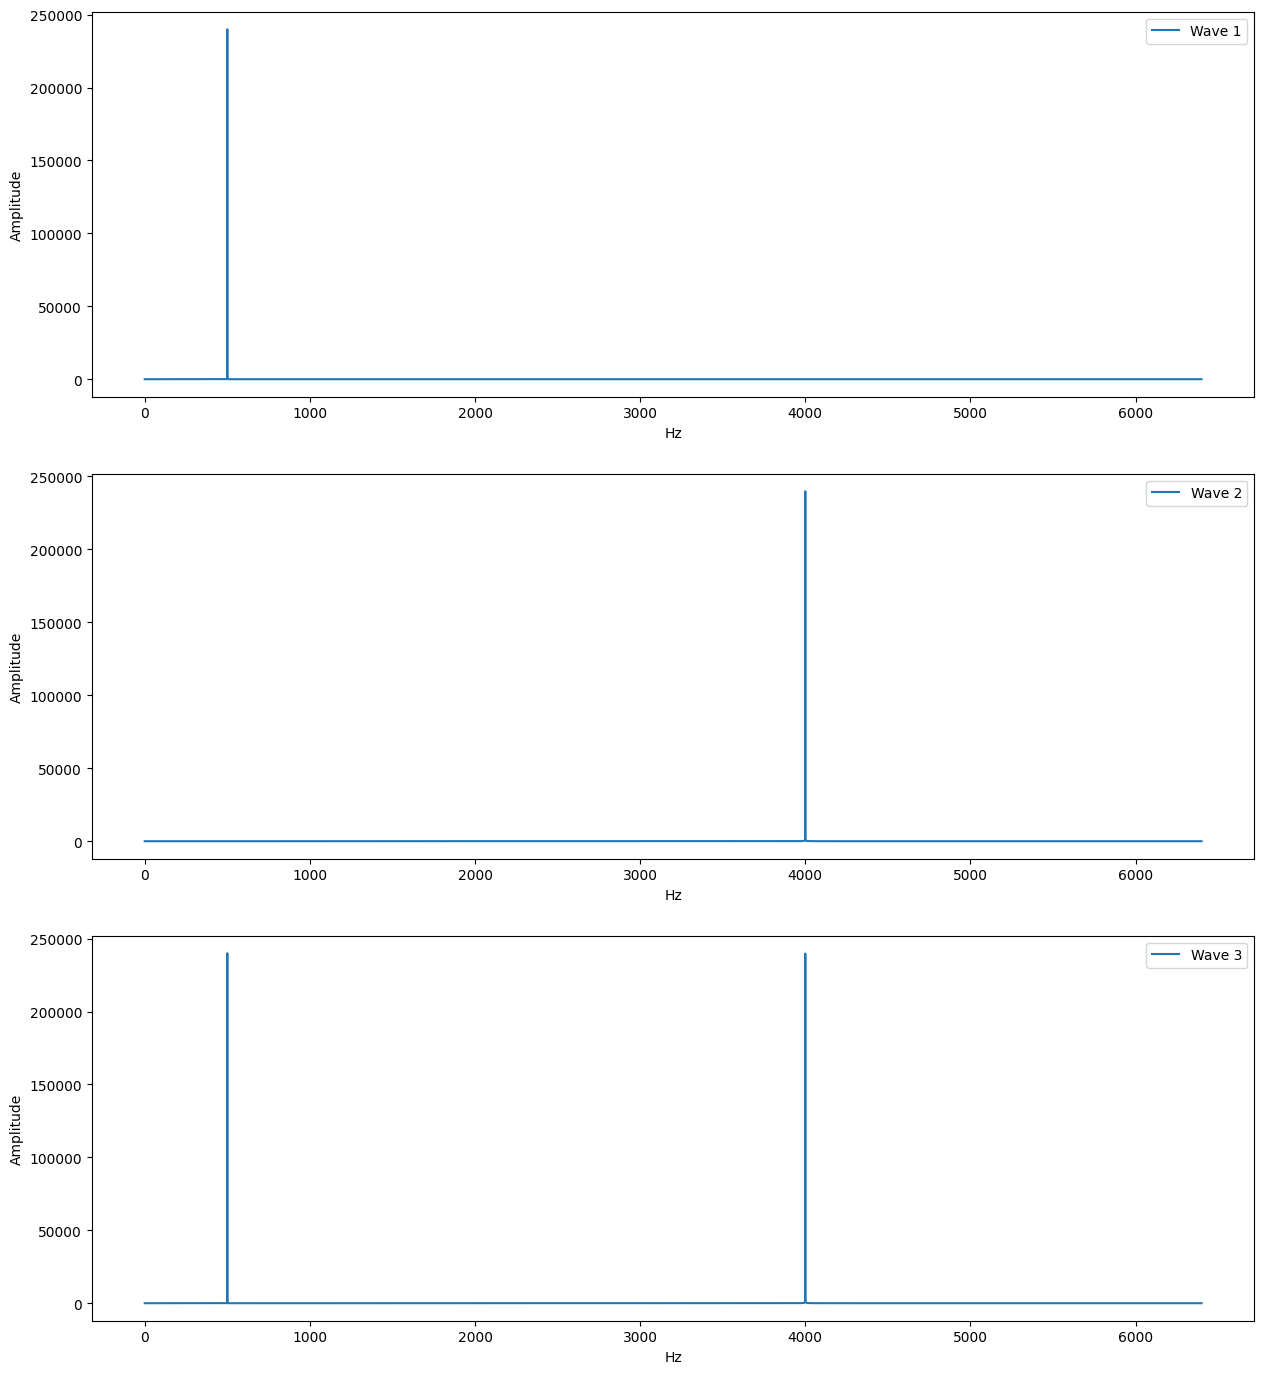

In [7]:
freq = np.fft.fftfreq(sr * duration, d=1/sr)
fig, axs = plt.subplots(3, 1, figsize=(15, 17))

scale_down = (sr * duration)//25

for i, wave in enumerate(waves):
    fft = np.fft.fft(wave)
    mag = np.abs(fft)
    axs[i].plot(freq[:scale_down], mag[:scale_down], label=f"Wave {i+1}")
    axs[i].legend()
    axs[i].set_xlabel('Hz')
    axs[i].set_ylabel('Amplitude')

plt.show()

In [24]:
def resample(signal, new_fs, old_fs):
    signal = torch.Tensor(signal)
    resample_transform = torchaudio.transforms.Resample(old_fs, new_fs)
    resampled_signal = resample_transform(signal)
    return resampled_signal.numpy()


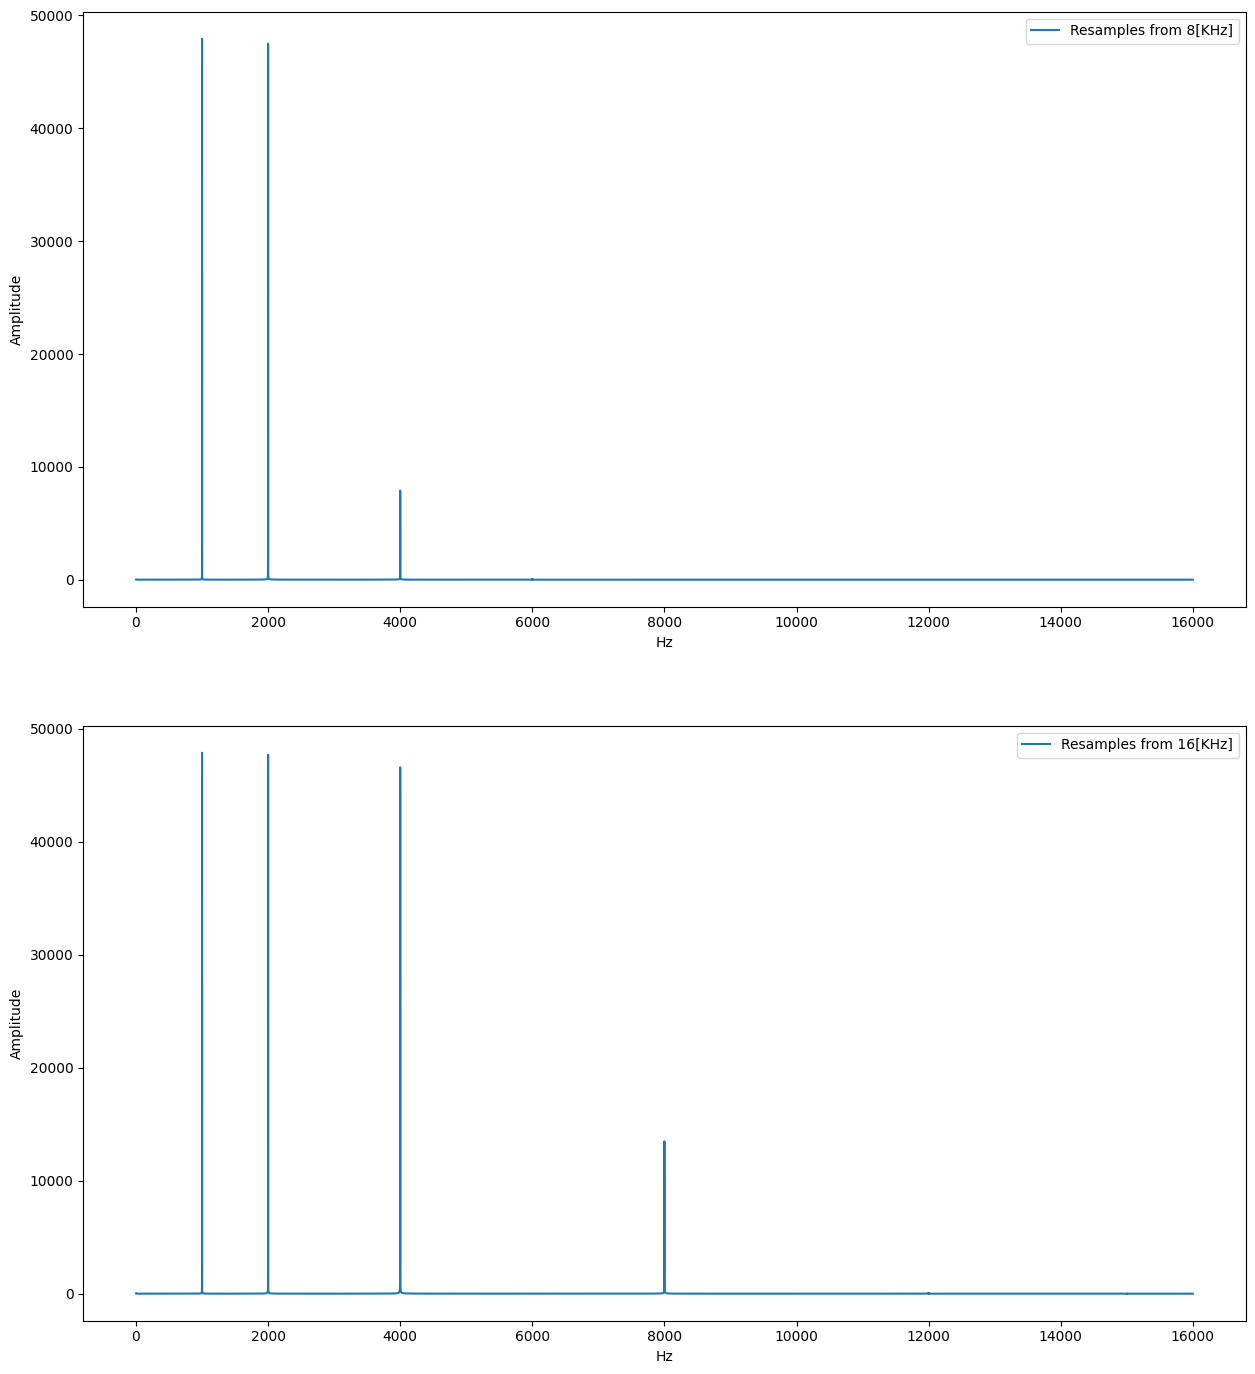

In [25]:
sr = 32000
duration = 3
time_span = time_span = np.linspace(0, duration, sr*duration)
# create wave
frequencies = [2**i * 1000 for i in range(5)]
wave = sum([np.sin(2 * np.pi * f * time_span) for f in frequencies])


downsampled_16 = resample(wave, 16000, 32000)
downsampled_8 = resample(wave, 8000, 32000)

resampled_16 = resample(downsampled_16, 32000, 16000)
resampled_8 = resample(downsampled_8, 32000, 8000)


freq = np.fft.fftfreq(sr * duration, d=1/sr)
fig, axs = plt.subplots(2, 1, figsize=(15, 17))

scale_down = (sr * duration)//2
waves = [resampled_8, resampled_16]

for i, w in enumerate(waves):
    fft = np.fft.fft(w)
    mag = np.abs(fft)
    axs[i].plot(freq[:scale_down], mag[:scale_down], label=f"Resamples from {(i+1)*8}[KHz]")
    axs[i].legend()
    axs[i].set_xlabel('Hz')
    axs[i].set_ylabel('Amplitude')

plt.show()


In [10]:
# Place your code for this part here